In [1]:
using Revise
using ITensors
using PastaQ
push!(LOAD_PATH,"../src/")
using RandomMeas
using ProgressBars
using MAT

In [2]:
## parameters 
N = 10
times = [0,1,2,3,4,5] ## quench time between 0 to 5 ms
ntimes = length(times)
ξ = siteinds("Qubit", N);
nu, NM = 500,150
data = zeros(Int8,ntimes,nu,NM,N);
n = 6
NAmax = 8;

In [3]:
#Load theory state
ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NAmax,n-1)
S = zeros(Float64,ntimes,NAmax,n-1)
SvN = zeros(Float64,ntimes,NAmax)
ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NAmax
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]')
            end
        end
        for nt in 2:n
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
        D, = eigen(ρA,ξ[1:NA]',ξ[1:NA];ishermitian=true)
        for k in 1:2^NA
            if D[k,k]>1e-12
                SvN[s,NA] -= D[k,k]*log2(D[k,k])
            end
        end
    end
end

In [4]:
u = Vector{Vector{Vector{ITensor}}}()
for s in 1:ntimes
    vars = matread("BrydgesScience2019data/unitaries_10_T_" * string(times[s]) * "_flr_1.mat")
    raw_measurements = vars["qstates" * string(times[s])]

    for r in 1:nu
        for m in 1:NM
            data[s,r,m,:] = reverse(digits(floor(Int,raw_measurements[r,m]), base=2, pad=N) .+ 1)
        end
    end    
    
    ut = Vector{Vector{ITensor}}()
    for r in 1:nu
        push!(ut,[ITensor(vars["unitaries"][r,i],ξ[i]',ξ[i]) for i in 1:N])
    end
    push!(u,ut)
end

In [5]:
#Purity from Hamming and shadow formulas
p_hamming = zeros(Float64,ntimes,NAmax)
p_shadow = zeros(Float64,ntimes,NAmax)
for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        p_hamming[s,NA] = get_purity_hamming(data[s,:,:,1:NA],ξ[1:NA])
        p_shadow[s,NA] = get_purity_shadows(data[s,:,:,1:NA],uA,ξ[1:NA])
    end
end

0.0%┣                                               ┫ 0/6 [00:03<00:-18, -3s/it]
16.7%┣███████▏                                   ┫ 1/6 [02:43<Inf:Inf, InfGs/it]
33.3%┣███████████████▍                              ┫ 2/6 [02:54<11:36, 174s/it]
50.0%┣███████████████████████▌                       ┫ 3/6 [03:05<04:38, 93s/it]
66.7%┣███████████████████████████████▍               ┫ 4/6 [03:16<02:11, 65s/it]
83.3%┣███████████████████████████████████████▏       ┫ 5/6 [03:27<00:52, 52s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [03:35<00:00, 43s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [03:35<00:00, 43s/it]


In [6]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow = zeros(Float64,ntimes,NAmax,n-1)
S_bshadow = zeros(Float64,ntimes,NAmax,n-1)
for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        ξA = ξ[1:NA]
        ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
        p_bshadow[s,NA,:] = get_moments(ρs, ξA, n, nu)
        for nt in 2:n
            S_bshadow[s,NA,nt-1]= log2(p_bshadow[s,NA,nt-1])/(1-nt)
        end
    end
end

0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]
16.7%┣███████▏                                   ┫ 1/6 [00:35<Inf:Inf, InfGs/it]
33.3%┣███████████████▊                               ┫ 2/6 [01:12<04:47, 72s/it]
50.0%┣███████████████████████▌                       ┫ 3/6 [01:48<02:42, 54s/it]
66.7%┣███████████████████████████████▍               ┫ 4/6 [02:26<01:38, 49s/it]
83.3%┣███████████████████████████████████████▏       ┫ 5/6 [03:11<00:48, 48s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [03:57<00:00, 47s/it]
100.0%┣██████████████████████████████████████████████┫ 6/6 [03:57<00:00, 47s/it]


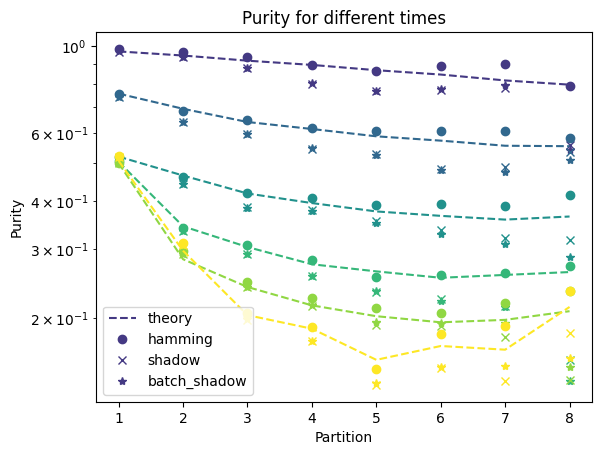

PyObject Text(0.5, 1.0, 'Purity for different times')

In [7]:
using PyPlot
cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NAmax,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NAmax,p_hamming[s,:],"o",color=cm(s/ntimes))
    plot(1:NAmax,p_shadow[s,:],"x",color=cm(s/ntimes))
    plot(1:NAmax,p_bshadow[s,:,1],"*",color=cm(s/ntimes))
end
yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

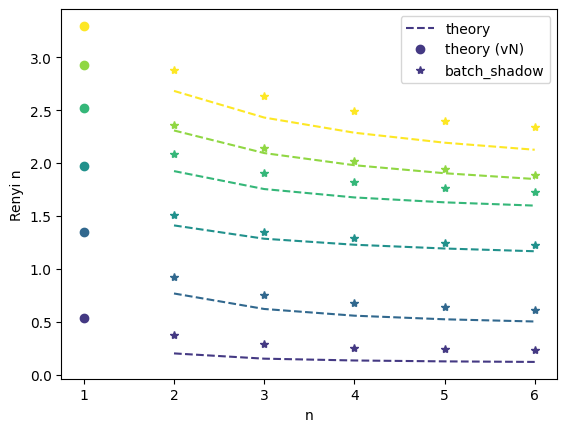

PyObject <matplotlib.legend.Legend object at 0x7f9affecda10>

In [8]:
using PyPlot
co = ["blue","red","green","magenta","orange","black"]
NA = 5
for s in 1:ntimes
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes))
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes))
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes))
end
#yscale("log")
xlabel("n")
ylabel("Renyi n")
legend(["theory","theory (vN)","batch_shadow"])